In [0]:
#Import Dataset 1
import pyspark
from pyspark.sql.functions import col,lit
from pyspark.sql.types import IntegerType

# File location and type
file_location_1 = "/FileStore/tables/esea_meta_demos_part1.csv" 
file_type_1 = "csv"

# CSV options
infer_schema = "false"
first_row_is_header = "true"
delimiter = ","


# The applied options are for CSV files. For other file types, these will be ignored.
df1 = spark.read.format(file_type_1) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(file_location_1)

#df1 = df1.drop(df1.start_seconds, df1.end_seconds, df1.winner_team, df1.round_type,df1.ct_eq_val, df1.t_eq_val)
df1 = df1.drop(df1.start_seconds, df1.end_seconds, df1.winner_team, df1.round_type)
df1.withColumn("is_bomb_planted", lit('False')).show()
df1 = df1.withColumn("ct_eq_val", df1["ct_eq_val"].cast(IntegerType()))
df1 = df1.withColumn("t_eq_val", df1["t_eq_val"].cast(IntegerType()))
df1.printSchema()



+--------------------+-----------+-----+----------------+---------+--------+---------------+
|                file|        map|round|     winner_side|ct_eq_val|t_eq_val|is_bomb_planted|
+--------------------+-----------+-----+----------------+---------+--------+---------------+
|esea_match_137709...|de_overpass|    1|       Terrorist|     4300|    4250|          False|
|esea_match_137709...|de_overpass|    2|       Terrorist|     6300|   19400|          False|
|esea_match_137709...|de_overpass|    3|       Terrorist|     7650|   19250|          False|
|esea_match_137709...|de_overpass|    4|       Terrorist|    24900|   23400|          False|
|esea_match_137709...|de_overpass|    5|CounterTerrorist|     5400|   20550|          False|
|esea_match_137709...|de_overpass|    6|       Terrorist|    29650|   25450|          False|
|esea_match_137709...|de_overpass|    7|       Terrorist|     3200|   25300|          False|
|esea_match_137709...|de_overpass|    8|CounterTerrorist|     4850|   

In [0]:
#Import Dataset 2
# File location and type
file_location_2 = "/FileStore/tables/esea_master_kills_demos_part1.csv" 
file_type_2 = "csv"

# CSV options
infer_schema = "false"
first_row_is_header = "true"
delimiter = ","


# The applied options are for CSV files. For other file types, these will be ignored.
df2 = spark.read.format(file_type_2) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(file_location_2)


df2 = df2.drop("tick", "seconds", "att_team", "vic_team", "att_side", "vic_side", "wp", "wp_type", "ct_alive", "t_alive")
df2 = df2.filter(df2.is_bomb_planted != 'False')
df2 = df2.distinct()
df2.printSchema()
display(df2)

root
 |-- file: string (nullable = true)
 |-- round: string (nullable = true)
 |-- is_bomb_planted: string (nullable = true)



file,round,is_bomb_planted
esea_match_13779835.dem,23,True
esea_match_13779836.dem,29,True
esea_match_13779846.dem,19,True
esea_match_13779851.dem,11,True
esea_match_13779879.dem,16,True
esea_match_13779888.dem,21,True
esea_match_13779938.dem,12,True
esea_match_13779973.dem,4,True
esea_match_13779982.dem,1,True
esea_match_13780000.dem,10,True


In [0]:
#Combine Dataset 1 & 2
import pyspark
from pyspark.sql.functions import col,lit, when

dfBig = df1.join(df2, (df1.file == df2.file) & (df1.round == df2.round), "left").drop(df2.file, df2.round)
dfBig = dfBig.na.fill("False")
dfBig = dfBig.drop('file')
dfBig = dfBig.withColumn('winner_side', when(col('winner_side') == 'None', 'Terrorist').otherwise(col('winner_side')))
dfBig = dfBig.withColumn("round", dfBig["round"].cast(IntegerType()))

dfBig = dfBig.where(dfBig.map == 'de_train')
dfBig = dfBig.drop('map')

dfBig.head()

Out[134]: Row(round=1, winner_side='Terrorist', ct_eq_val=4250, t_eq_val=4300, is_bomb_planted='True')

In [0]:
#Import needed Libraries for NaiveBayes
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from IPython.core.display import HTML
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

In [0]:
#Form training and test data for model
from sklearn.model_selection import train_test_split

#Convert pyspark dataframe to Pandas dataframe
newdf = dfBig.toPandas()

#Convert string column into 0 or 1
newdf['winner_side'] = np.where(newdf['winner_side']=='Terrorist',1,0)

x = newdf.drop(['winner_side'], axis=1)
y = newdf['winner_side']

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.4, random_state = 0)



X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)

print(X_train.shape)
print(X_test.shape)

(4399, 5)
(2933, 5)


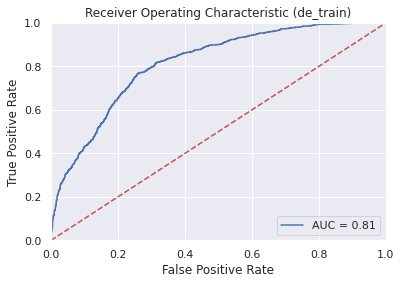

In [0]:
#Run NaiveBayes on train data to create model, then run test data on model and plot graph
naiveb = GaussianNB()
naiveb = naiveb.fit(X_train, y_train)
naiveb

pred_test = naiveb.predict(X_test)
pred_test_prob = naiveb.predict_proba(X_test)

fpr, tpr, thresholds = metrics.roc_curve(y_test, pred_test_prob[:,1])
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic (de_train)')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [0]:
#Print AUC and Accuracy
print('AUC', round(metrics.roc_auc_score(y_test, pred_test_prob[:,1]),2))
print('Overall Accuracy', round(metrics.accuracy_score(y_test, pred_test),2))

AUC 0.81
Overall Accuracy 0.75


In [0]:
#Create Confusion Matrix of model
confmat = metrics.confusion_matrix(y_test, pred_test)
confmat

Out[144]: array([[1189,  385],
       [ 360,  999]])

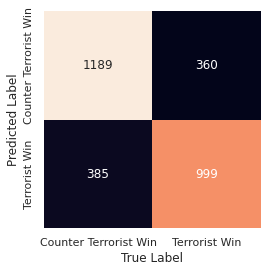

In [0]:
#Plot Confusion Matrix
sns.heatmap(confmat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['Counter Terrorist Win','Terrorist Win'], yticklabels=['Counter Terrorist Win','Terrorist Win'])
plt.xlabel('True Label')
plt.ylabel('Predicted Label');